In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make
import pandas as pd

In [4]:
a = [1]*10
b = [2]*12
c = [11,2,34,65]

dat = pd.DataFrame({'a':a})
dat1 = pd.DataFrame({'b':b})

In [3]:
import pandas as pd

In [21]:
pd.DataFrame({'a': [1,2,3,4], 'b': [4,4,5,4]})

,a,b
0,1,4
1,2,4
2,3,5
3,4,4


In [22]:
df = pd.DataFrame(dat)

In [23]:
df

,a
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [2]:
class leastSquaresGD:
    def __init__(self, error):
        # original copies to reference back to
        self.x_original = None  
        self.a_original = None
        self.b_original = None
        # the copies
        self.x = None      # weights
        self.a = None      # xTrain
        self.b = None      # coeff
        self.initialTime = None # starting time
        self.error = error   # epsilon
        self.grad = None    # current gradient
        self.norm = None    # current norm of gradient
        self.lam = None     # current step size
        self.gr = None      # list of values of norms of gradient
        self.theta = None   # theta value used in Adpative
        # Plots for different methods
        self.vanPlt = None  
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = 0         # maximum value for x axis in plt
        self.time = None
        
    def get_ds(self, ds, Import = True):
        # can use 'make_regression', 'load_boston', 'fetch_california_housing', 'load_diabetes'
        if Import == True:
            dataset = ds(return_X_y=True)
        else:
            dataset = ds()
        self.a_original = dataset[0]
        self.b_original = dataset[1]
        self.x_original = np.random.rand(len(self.a_original[0]))
        
    def generate(self, function, dim, vec_len, scale):
        for i in range(dim):
            globals()['X'+str(i)] = [0]*vec_len
        for j in range(vec_len):
            globals()['X'+str(0)][j] = (random.random()+1e-12)*scale
            y = function(globals()['X'+str(0)][j])
            noiz = 3
            for k in range(dim):
                globals()['X'+str(k)][j] = y + np.random.normal(0,noiz)
                noiz += 3
        A = np.array([globals()['X'+str(i)] for i in range(dim)]).T
        self.a_original = A
        self.x_original = np.random.rand(len(A[0]))*scale
        self.b_original = A @ self.x_original + np.random.normal(0,3,(A @ self.x_original).shape)
        
    def f(self, X):
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g(self, X):
        return self.a.T @ (self.a @ X - self.b)
    def Step(self):
        self.x = self.x - self.lam*self.grad
    
    def normal(self, X): 
        return np.linalg.norm(X)
    
    def Vanilla(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.lam = 1/L
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            self.Step()
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.lam = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldX = deepcopy(self.x)
        self.grad = self.g(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam
            min2 = ( np.linalg.norm( self.x - oldX ) ) \
                / ( 2 * np.linalg.norm(self.g(self.x) - self.g(oldX) ) )
            self.lam = np.min([min1,min2])
            oldX = deepcopy(self.x)
            self.Step() # update x
            self.theta = self.lam/oldLam
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
        self.PrintResults()
    
    def BackTrack(self):
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( self.normal( lam * self.grad ) / \
                     ( self.normal( self.g( self.x - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lam = lam

    def LineSearch(self):
        self.initialTime = time.time()
#         self.lam_list = []
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            self.BackTrack()
            self.Step()
            self.grad =  self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.PrintResults()
    
    def Barzilai(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.lam = random.random()+1e-12
        oldX = deepcopy(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            self.lam = np.dot( self.x - oldX, self.g(self.x) - self.g(oldX) ) \
                        / np.linalg.norm(self.g(self.x) - self.g(oldX))**2
            oldX = deepcopy(self.x)
            self.Step()
            self.grad = self.g(self.x)
            self.norm =  self.normal(self.grad)
            self.gr.append( self.norm)
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(len(self.gr),600) , 'r', self.BazPlt, 'Barzalai {} sec'.format(self.time))
        self.PrintResults()
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient in domain [{}, {}]'.format(0,self.Max) )
        plt.savefig('plots2.png', dpi=100)
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr), ':')
        print('x vector is:', self.x)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', self.time)
        print('Final Lambda value: ', self.lam)

In [ ]:
random.random()

In [18]:
def linFunc(x):
    return 2*x + 5

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 1396 :
x vector is: [0.83723031 0.05601499 0.86199476 0.38870389 0.50315957 0.02992396
 0.93583429 0.8234715  0.84630531 0.29451069]
Gradient Norm is: 9.977617522095208e-07
Time taken: 0.03
Final Lambda value:  8.33862462749191e-06

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 226 :
x vector is: [0.83723031 0.05601499 0.86199476 0.38870389 0.50315957 0.02992396
 0.93583429 0.8234715  0.84630531 0.29451069]
Gradient Norm is: 9.773141197760425e-07
Time taken: 0.56
Final Lambda value:  1.3681121397243039e-05

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 551 :
x vector is: [0.83723031 0.05601499 0.86199476 0.38870389 0.50315957 0.02992396
 0.93583429 0.8234715  0.84630531 0.29451069]
Gradient Norm is: 9.88923175004403e-07
Time taken: 0.04
Final Lambda value:  7.841740400327821e-06

 Barzi

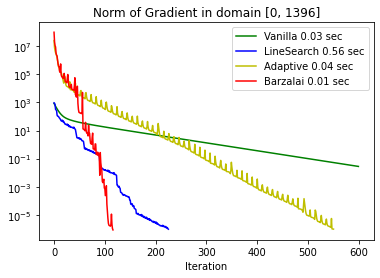

In [19]:
G = leastSquaresGD(1e-6)
G.generate(linFunc,10,100, 1)
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.Barzilai()
G.PrintPlots()

In [ ]:
G = leastSquaresGD(1e-6)
G.get_ds(Make, Import=False)
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.Barzilai()
G.PrintPlots()